1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

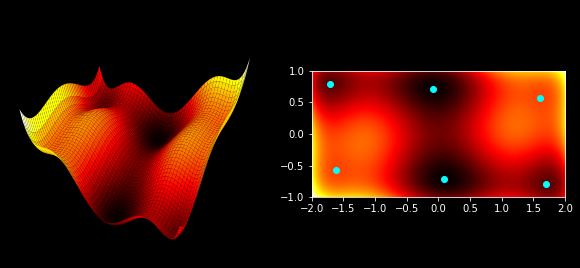

6 minima found:
[X Y]: [-1.704  0.796]; [-1.607 -0.569]; [-0.09   0.713]; [ 0.09  -0.713]; [1.607 0.569]; [ 1.704 -0.796]
With values:
f(x, y): -0.215; 2.104; -1.032; -1.032; 2.104; -0.215
For x0 = (0, 0), we arrive at the extrema: [0. 0.] which is in fact a saddle point, from the 3D graph.


In [1]:
import math as m

import numpy
import numpy as np
from scipy import optimize
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use("dark_background")

def f(x):
    return (4.0 - 2.1 * x[0] ** 2 + (x[0] ** 4) / 3) * x[0] ** 2 + x[0] * x[1] + (4.0 * x[1] ** 2 - 4) * x[1] ** 2


bounds=[(-2, 2), (-1, 1)]
initial_x = [-0.9, 1.5]
minimum = optimize.minimize(f, bounds=bounds, x0=initial_x)
minima = np.array(([minimum.x[0]], [minimum.x[1]]))
for it in range(0, 150):
    initial_x[0] = np.random.uniform(low=-2.0, high=2.0)
    initial_x[1] = np.random.uniform(low=-1.0, high=1.0)
    minimum = optimize.minimize(f, bounds=bounds, x0=initial_x)
    minima = np.hstack((minima, np.array(([minimum.x[0]], [minimum.x[1]]))))
minima = np.unique(minima.round(decimals=3), axis=1)
fig = plt.figure(figsize=(10, 10))
x1 = np.arange(-2, 2, 0.02)
y1 = np.arange(-1, 1, 0.01)
x1, y1 = np.meshgrid(x1, y1)
ax = fig.add_subplot(1, 2, 1, projection="3d")
ax.view_init(elev=45, azim=295)
ax.dist = 8.5
z1 = f(np.array([x1, y1]))
ax.plot_surface(x1, y1, z1, cmap="hot")
ax.set_axis_off()
ax = fig.add_subplot(1, 2, 2)
ax.imshow(z1, cmap="hot", extent=[-2, 2, -1, 1], origin="lower")
ax.scatter(minima[0], minima[1], marker="o", color="aqua")
ax.set_axis_on()
plt.show()
print(len(minima[0, :]), "minima found:")
print("[X Y]:", end=" ")
print(*minima.T, sep="; ")
print("With values:")
print("f(x, y):", end=" ")
z1 = f(minima).round(decimals=3)
print(*z1, sep="; ")
minimum = optimize.minimize(f, bounds=bounds, x0=np.array([0.0, 0.0]))
print("For x0 = (0, 0), we arrive at the extrema:", minimum.x, "which is in fact a saddle point, from the 3D graph.")

2\. **Curve fitting of temperature in Alaska**

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

Max temps gaussian fit:
	mean = 5.74 +- 0.08
	std = 2.29 +- 0.17
	h = 15.78 +- 1.18
	a = 23.09 +- 1.15
	R^2 = 0.99
Min temps gaussian fit:
	mean = 6.16 +- 0.05
	std = 1.98 +- 0.08
	h = -61.32 +- 1.19
	a = 52.65 +- 1.40
	R^2 = 0.99


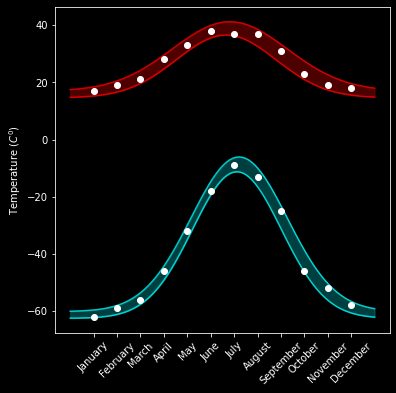

In [8]:
import calendar
months = np.array(calendar.month_name)
months = months[1:]
max_temp = np.array([17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18])
min_temp = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])

def gaussian(x, mean, std, h, amp):
    return h + amp * np.exp(-0.5 * ((x - mean) / std) ** 2)


init_param = (6, 2, np.min(max_temp), 20)
opt_param, cov_param = optimize.curve_fit(gaussian, xdata=np.arange(0, 12),
                                           ydata=max_temp, p0=init_param,
                                           bounds=([4, 1, -60, 20], [8, 10, 40, 60]))
xg = np.linspace(-1, 12, 100)
max_param = opt_param + np.sqrt(cov_param.diagonal())
y_max = gaussian(xg, *max_param)
fig = plt.figure(figsize=(6, 6))
plt.plot(xg, y_max, label='$\mu$=%5.3f, $\sigma$=%5.3f, h=%5.3f, a=%5.3f' % tuple(opt_param),
         alpha=0.75, color="r", zorder=1)
min_param = opt_param - np.sqrt(cov_param.diagonal())
y_min = gaussian(xg, *min_param)
plt.plot(xg, y_min, label='$\mu$=%5.3f, $\sigma$=%5.3f, h=%5.3f, a=%5.3f' % tuple(opt_param),
         alpha=0.75, color="r", zorder=1)
plt.fill_between(xg, y_max, y_min, alpha=0.3, color="r", zorder=1)
residuals = max_temp - gaussian(np.arange(0, 12), *opt_param)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((max_temp - np.mean(max_temp))**2)
r_squared = 1 - (ss_res / ss_tot)
print("Max temps gaussian fit:")
print("\tmean = %.2f +- %.2f" % (opt_param[0], np.sqrt(cov_param[0,0])))
print("\tstd = %.2f +- %.2f" % (opt_param[1], np.sqrt(cov_param[1,1])))
print("\th = %.2f +- %.2f" % (opt_param[2], np.sqrt(cov_param[2,2])))
print("\ta = %.2f +- %.2f" % (opt_param[3], np.sqrt(cov_param[3,3])))
print("\tR^2 = %.2f" % r_squared)
init_param = (6, 2, np.min(min_temp), 40)
opt_param, cov_param = optimize.curve_fit(gaussian, xdata=np.arange(0, 12),
                                           ydata=min_temp, p0=init_param,
                                           bounds=([4, 1, -70, 20], [8, 10, 0, 60]))
max_param = opt_param + np.sqrt(cov_param.diagonal())
y_max = gaussian(xg, *max_param)
plt.plot(xg, y_max, label='$\mu$=%5.3f, $\sigma$=%5.3f, h=%5.3f, a=%5.3f' % tuple(opt_param),
         alpha=0.75, color="aqua", zorder=1)
min_param = opt_param - np.sqrt(cov_param.diagonal())
y_min = gaussian(xg, *min_param)
plt.plot(xg, y_min, label='$\mu$=%5.3f, $\sigma$=%5.3f, h=%5.3f, a=%5.3f' % tuple(opt_param),
         alpha=0.75, color="aqua", zorder=1)
plt.fill_between(xg, y_max, y_min, alpha=0.25, color="aqua", zorder=1)
residuals = min_temp - gaussian(np.arange(0, 12), *opt_param)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((min_temp - np.mean(min_temp))**2)
r_squared = 1 - (ss_res / ss_tot)
print("Min temps gaussian fit:")
print("\tmean = %.2f +- %.2f" % (opt_param[0], np.sqrt(cov_param[0,0])))
print("\tstd = %.2f +- %.2f" % (opt_param[1], np.sqrt(cov_param[1,1])))
print("\th = %.2f +- %.2f" % (opt_param[2], np.sqrt(cov_param[2,2])))
print("\ta = %.2f +- %.2f" % (opt_param[3], np.sqrt(cov_param[3,3])))
print("\tR^2 = %.2f" % r_squared)
plt.scatter(np.arange(0, 12), max_temp, color="w", zorder=2)
plt.scatter(np.arange(0, 12), min_temp, color="w", zorder=2)
plt.tick_params(axis='x', rotation=45)
plt.xticks(ticks=np.arange(0, 12, 1), labels=months)
plt.ylabel("Temperature ($C^0$)")
#plt.legend(bbox_to_anchor=(0.8, -.25))
plt.show()

We see that a gaussian fits the data reasonably well, because no parameter error is too large and the $R^2\sim1.0$ .

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't done it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function
of the independent variable "distances".

- Considering only the "residual" feature, create a histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the
number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of
the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

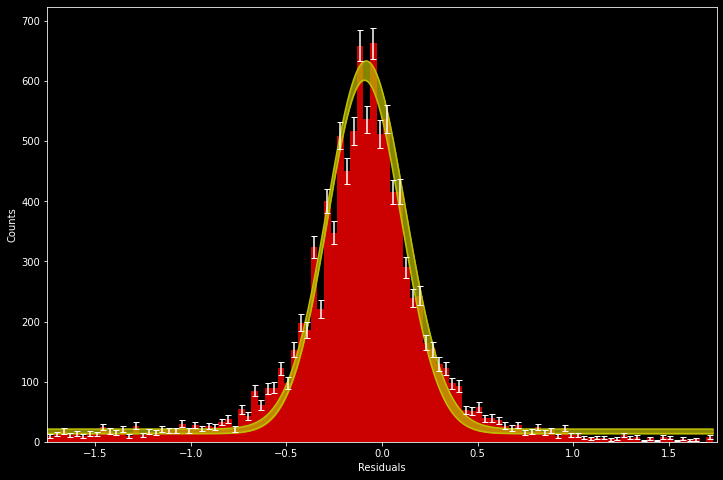

pvalue = 0.000000 which is satisfactory.


In [3]:
data = np.load('./data/residuals_261.pkl', allow_pickle=True)
res = data.item(0)["residuals"]
xl, xr = -1.75, 1.75
res = res[res > xl]
res = res[res < xr]
nbins = m.isqrt(len(res))
plt.figure(figsize=[2*x for x in plt.rcParams["figure.figsize"]])
counts = plt.hist(res, nbins, color="r", alpha=0.8)
midpoints = (counts[1][1:] + counts[1][:-1])/2
plt.errorbar(midpoints, counts[0], yerr=np.sqrt(counts[0]), fmt=" ", color="white", capsize=3.0, alpha=1, zorder=3)
plt.ylabel("Counts")
plt.xlabel("Residuals")
plt.xlim((xl, xr))
init_param = (0, 0.5, 0, 700)
opt_param, cov_param = optimize.curve_fit(gaussian, xdata=midpoints,
                                           ydata=counts[0], p0=init_param,
                                           bounds=([xl/2, 0, 0, 600], [xr/2, (xr - xl)/2, 50, 800]))
xg = np.linspace(counts[1][0], counts[1][-1], 1000)
max_param = opt_param + np.sqrt(cov_param.diagonal())
y_max = gaussian(xg, *max_param)
plt.plot(xg, y_max, label='$\mu$=%5.3f, $\sigma$=%5.3f, h=%5.3f, a=%5.3f' % tuple(opt_param),
         alpha=1, color="y")
min_param = opt_param - np.sqrt(cov_param.diagonal())
y_min = gaussian(xg, *min_param)
plt.plot(xg, y_min, label='$\mu$=%5.3f, $\sigma$=%5.3f, h=%5.3f, a=%5.3f' % tuple(opt_param),
         alpha=1, color="y")
plt.fill_between(xg, y_max, y_min, alpha=0.7, color="y", zorder=2)
plt.show()
x = xg
y = gaussian(xg, *opt_param)
b_hat = cov_param[0, 1] / cov_param[0, 0]
a_hat = np.mean(y - b_hat * x)
sigma_y = np.sqrt(np.abs(y))
chi2 = np.sum(((y - (a_hat + b_hat * x))**2) / sigma_y)
ndof = 4 - 1
pvalue = 1. - stats.chi2.cdf(chi2, ndof)
print(f"{pvalue = :.6f}", "which is satisfactory.")

4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted
  by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is necessary.

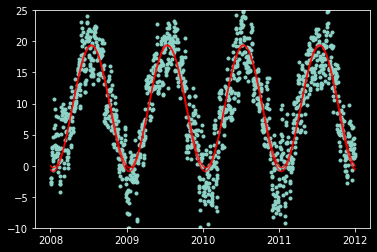

ss_res1 = 34359.961463792584


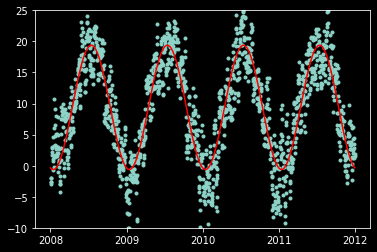

ss_res = 34359.42592517326
CL: 0.880 , additional parameter necessary: NO


0.880195455562175

In [18]:
data = np.loadtxt("data/munich_temperatures_average_with_bad_data.txt")
d1 = data[data[:, 0] >= 2008]
d1 = d1[d1[:, 0] <= 2012]

def cos(x, a, b, c):
    return - (c + a * np.cos(2 * m.pi * x + b))


init_param = (12, -0.2* m.pi, 0)
opt_param, cov_param = optimize.curve_fit(cos,
                                          xdata=d1[:, 0], ydata=d1[:, 1],
                                          p0=init_param,
                                          bounds=([10, - 0.3 * m.pi, -20], [15, 0.3 * m.pi, 0]))
xg = np.linspace(2008, 2012, 1000)
max_param = opt_param + np.sqrt(cov_param.diagonal())
y_max = cos(xg, *max_param)
plt.plot(xg, y_max,
         alpha=0.75, color="r", zorder=1)
min_param = opt_param - np.sqrt(cov_param.diagonal())
y_min = cos(xg, *min_param)
plt.plot(xg, y_min,
         alpha=0.75, color="r", zorder=1)
plt.fill_between(xg, y_max, y_min, alpha=0.25, color="r", zorder=1)
plt.scatter(d1[:, 0], d1[:, 1], marker=".")
plt.xticks(ticks=[x for x in range(2008, 2013)])
plt.ylim((-10, 25))
plt.show()
hot_temps = cos(xg[np.where(cos(xg, *opt_param) > 19.25)], *opt_param)
mean_hot_temps = np.mean(hot_temps)
cold_temps = cos(xg[np.where(cos(xg, *opt_param) < 0)], *opt_param)
mean_cold_temps = np.mean(cold_temps)
ss_res1 = np.sum((d1[:, 1] - cos(d1[:, 0], *opt_param)) ** 2)
print(f"{ss_res1 = }")

def cos2(x, a, b, c, d):
    return -(c + a * np.cos(2 * d * m.pi * x + b))
init_param = (12, -0.2* m.pi, 0, 1)
opt_param, cov_param = optimize.curve_fit(cos2,
                                          xdata=d1[:, 0], ydata=d1[:, 1],
                                          p0=init_param,
                                          bounds=([10, - 0.3 * m.pi, -20, 1], [15, 0.3 * m.pi, 0, 2]))
xg = np.linspace(2008, 2012, 1000)
plt.scatter(d1[:, 0], d1[:, 1], marker=".")
plt.xticks(ticks=[x for x in range(2008, 2013)])
plt.plot(xg, cos2(xg, *opt_param),
         alpha=1, color="r", zorder=1)
plt.ylim((-10, 25))
plt.show()
residuals = d1[:, 1] - cos2(d1[:, 0], *opt_param)
ss_res = np.sum(residuals**2)
print(f"{ss_res = }")
# define function for F-test
def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, nbins, verbose=False):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(nbins - ndof_2))
    CL = 1. - stats.f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print("CL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL


ndof_1 = 3 - 1
ndof_2 = 4 - 1
Ftest(ss_res1, ss_res, ndof_1, ndof_2, len(d1[:, 0]), verbose=True)

  a)
  - The best parameters are: `a= -10, b = -0.233, c = 9.38`.
  - Predictions: the average temperature is
`np.mean(cos(xg, *opt_param)) = 9.374`. The average hot (`>19.25`) temperature is `19.34`.
The average cold (`<0`) temperature is `-0.41`.
  - `b`is the initial phase: it doesn't have a physical meaning other than the temperature at the initial measurement

b)
  - `ss_res ~ 34359`
  - We don't need the new parameter, accorsing to the `Ftest()`, as the residues didn't improve.